# **Experimentación de la Redes Siamesas con la base datos "Georgia Tech"**

### Importando librerias

In [3]:
import sys
import numpy as np
import pandas as pd
from matplotlib.pyplot import imread
import pickle
import os
import matplotlib.pyplot as plt
%matplotlib inline

import cv2
import time
from PIL import Image

import tensorflow as tf
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate
from keras.models import Model

from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import Concatenate
from keras.layers.core import Lambda, Flatten, Dense
from keras.initializers import glorot_uniform

from keras.engine.topology import Layer
from keras.regularizers import l2
from keras import backend as K

from sklearn.utils import shuffle

import numpy.random as rng
from tqdm.notebook import tqdm



In [4]:
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import TensorBoard, ModelCheckpoint,EarlyStopping,ReduceLROnPlateau
from sklearn.model_selection import train_test_split

## 1. Implementacion del modelo

### 1.1 Funciones para inicializar parametros

Segun el [artículo](http://www.cs.utoronto.ca/~gkoch/files/msc-thesis.pdf) sugiere las siguientes inicializaciones para las capas CNN:
 - Pesos con una media de 0.0 y una desviación estándar de 0.01
 - Bias con una media de 0.5 y una desviación estándar de 0.01

In [5]:
def initialize_weights(shape, dtype=None):
    return np.random.normal(loc = 0.0, scale = 1e-2, size = shape)

In [6]:
def initialize_bias(shape, dtype=None):
    return np.random.normal(loc = 0.5, scale = 1e-2, size = shape)

### 1.2 Modelo Red Siamesa

Arquitectura a bajo nivel de la red siames

![siamese_network_architecture](assets/siamese_network_architecture.png)

In [7]:
def get_siamese_model(input_shape):
    # Se define la dimensión de los tensores para las dos entradas de imágenes
    left_input = Input(input_shape)
    right_input = Input(input_shape)
    
    # Red Neuronal Convolucional
    model = Sequential()
    model.add(Conv2D(64, (10,10), activation='relu', input_shape=input_shape,
                   kernel_initializer=initialize_weights, kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D())
    model.add(Conv2D(128, (7,7), activation='relu',
                     kernel_initializer=initialize_weights,
                     bias_initializer=initialize_bias, kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D())
    model.add(Conv2D(128, (4,4), activation='relu', kernel_initializer=initialize_weights,
                     bias_initializer=initialize_bias, kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D())
    model.add(Conv2D(256, (4,4), activation='relu', kernel_initializer=initialize_weights,
                     bias_initializer=initialize_bias, kernel_regularizer=l2(2e-4)))
    model.add(Flatten())
    model.add(Dense(4096, activation='sigmoid',
                   kernel_regularizer=l2(1e-3),
                   kernel_initializer=initialize_weights,bias_initializer=initialize_bias))
    
    # Generar los vectores caracteristicos para las dos imágenes
    encoded_l = model(left_input)
    encoded_r = model(right_input)
    
    # Agregar la capa personalizada para calcular la diferencia absoluta entre los vectores caracteristicos de las dos imágenes
    L1_layer = Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))
    L1_distance = L1_layer([encoded_l, encoded_r])
    
    # Agregar la capa densa el cuál generará el puntaje de similitud
    # Por medio de la función de activación sigmoid nos indicará con 0 si las dos imágenes son diferentes y 1 si son similares
    prediction = Dense(1,activation='sigmoid',bias_initializer=initialize_bias)(L1_distance)
    
    # Conectar las entradas con la salida
    siamese_net = Model(inputs=[left_input,right_input],outputs=prediction)
    
    # Retornar el modelo
    return siamese_net

#### 1.2.1. Resumen del modelo

In [8]:
model = get_siamese_model((105, 105, 3))
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 105, 105, 3) 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 105, 105, 3) 0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 4096)         38960448    input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 4096)         0           sequential[1][0]             

#### 1.2.2. Compilación del modelo

In [9]:
optimizer = Adam(lr = 0.00006)
model.compile(loss="binary_crossentropy",optimizer=optimizer, metrics=["acc"])

## 2. Importar datos
Se escogio el dataset de Georgia Tech debido a que brinda una gran cantidad de imagenes a colores y porque la posicion de los rostros varian considerablemente, lo que haria al modelo mas robusto. Este dataset contiene 750 imagenes en formato .jpg, pertenecientes a 50 personas. Se decidio agrupar las imagenes en 50 carpetas con 15 imagenes cada una. Ademas,se cambiaron las etiquetas dentro de cada carpeta a un numero entre 1 a 15. 

A partir de esta distribucion, se realizo un pequeño programa para escoger de manera aleatoria parejas iguales(imagenes dentro de la misma carpeta) y parejas sin similitud(imagenes en diferentes carpetas). Se escogieron 10000 parejas iguales y 10000 parejas sin similitud para mantener una correcta distribucion. Esta informacion se guardo como direciones de la imagen dentro de un DataFrame. Si las parejas sin similares el campo "Igualdad" es 1 y si son diferentes es 0. 

In [14]:
Data=pd.read_csv("Imagenes_siamesas.csv")

In [15]:
Data.head()

,Imagen1,Imagen2,Igualdad
0,s1/5.jpg,s1/6.jpg,1.0
1,s1/7.jpg,s1/2.jpg,1.0
2,s1/9.jpg,s1/10.jpg,1.0
3,s1/3.jpg,s1/5.jpg,1.0
4,s1/3.jpg,s1/10.jpg,1.0


### 2.1 Transformando a entero la variable de igualdad

In [16]:
Data["Igualdad"]=Data["Igualdad"].astype(int)

### 2.2 Separando en train y validation set
Lo ideal es tener un train y test set que tengan una distribucion similar, por lo que se realizara una separacion estratificada con respecto a la columna "Igualdad"

In [17]:
df_train,df_val=train_test_split(Data,test_size=0.15,stratify=Data["Igualdad"])

In [18]:
df_val=df_val.reset_index(drop=True)

## 3. Funciones de entrenamiento

In [19]:
images_path="data_georgia/cropped_faces"

### 3.1 Creando ImageDataGenerators para el entrenamiento
Utilizando la funcion de ImageDataGenerator, creare dos nuevos generadores de imagenes que brinden dos imagenes de entrada al modelo segun la informacion brindada en el Dataframe que pasa a la funcion. 

Para los datos de entrada se realiza un poco de data augmentation al agregarle un angulo de rotacion de 5° y haciendo un maximo zoom de 10%. Esto no aplica para las imagenes de validacion.

Información importante:
- batch_size: 32
- tamaño de la imagen: 105x105x3
- rotation_range=5
- zoom_range=0.1

In [20]:
train_generator=ImageDataGenerator(rescale=1./255,
                                   rotation_range=5,
                                   zoom_range=0.1)
test_generator=ImageDataGenerator(rescale=1./255)
val_generator=ImageDataGenerator(rescale=1./255)

In [21]:
def gen_train_flow_for_two_inputs(X1, X2, y):
    genX1 =train_generator.flow_from_dataframe(dataframe=df_train,
                                                 directory=images_path,
                                                 x_col=X1,
                                                 y_col=y,
                                                  target_size=(105,105),
                                                  batch_size=32,
                                                  class_mode="raw",
                                                  seed=42)
    genX2 = train_generator.flow_from_dataframe(dataframe=df_train,
                                                 directory=images_path,
                                                 x_col=X2,
                                                 y_col=y,
                                                  target_size=(105,105),
                                                  batch_size=32,
                                                  class_mode="raw",
                                                  seed=42)
    while True:
        X1i = genX1.next()
        X2i = genX2.next()
        yield [X1i[0], X2i[0]], X1i[1]

In [22]:
def gen_val_flow_for_two_inputs(X1, X2, y):
    genX1 =val_generator.flow_from_dataframe(dataframe=df_val,
                                                 directory=images_path,
                                                 x_col=X1,
                                                 y_col=y,
                                                  target_size=(105,105),
                                                  batch_size=32,
                                                  class_mode="raw",
                                                  seed=42)
    genX2 = val_generator.flow_from_dataframe(dataframe=df_val,
                                                 directory=images_path,
                                                 x_col=X2,
                                                 y_col=y,
                                                  target_size=(105,105),
                                                  batch_size=32,
                                                  class_mode="raw",
                                                  seed=42)
    while True:
        X1i = genX1.next()
        X2i = genX2.next()
        yield [X1i[0], X2i[0]], X1i[1]

In [23]:
gen_train_flow = gen_train_flow_for_two_inputs("Imagen1", "Imagen2", "Igualdad")

In [24]:
gen_val_flow = gen_val_flow_for_two_inputs("Imagen1", "Imagen2", "Igualdad")

## 4. Entrenamiento Modelo
Para descargar el modelo entrenado ingresar a este enlace: [RS_georgia_db.h5](https://drive.google.com/file/d/1leTDVAZKUgVgrrnplric7jT10q8hKU_5/view?usp=sharing)

In [21]:
mc = ModelCheckpoint('RS_georgia_db.h5', monitor='val_loss', mode='min', save_best_only=True)
red_lr_plat = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=7, verbose=1, mode='auto', cooldown=5, min_lr=0.0001)
callbacks = [mc, red_lr_plat]
logs = model.fit_generator(gen_train_flow,
                            steps_per_epoch = 400,
                            validation_data = gen_val_flow,
                            validation_steps = 80,
                            epochs = 10,
                            callbacks= callbacks)

Epoch 1/10
400/400 [==============================] - 3505s 9s/step - loss: 1.7824 - acc: 0.8026 - val_loss: 0.9254 - val_acc: 0.8285
Epoch 2/10
400/400 [==============================] - 3505s 9s/step - loss: 0.6229 - acc: 0.8746 - val_loss: 0.4748 - val_acc: 0.9103
Epoch 3/10
400/400 [==============================] - 3500s 9s/step - loss: 0.3732 - acc: 0.9325 - val_loss: 0.2779 - val_acc: 0.9534
Epoch 4/10
400/400 [==============================] - 3499s 9s/step - loss: 0.2713 - acc: 0.9554 - val_loss: 0.2164 - val_acc: 0.9581
Epoch 5/10
400/400 [==============================] - 3506s 9s/step - loss: 0.2106 - acc: 0.9698 - val_loss: 0.1722 - val_acc: 0.9706
Epoch 6/10
400/400 [==============================] - 3492s 9s/step - loss: 0.1775 - acc: 0.9777 - val_loss: 0.1489 - val_acc: 0.9639
Epoch 7/10
400/400 [==============================] - 3487s 9s/step - loss: 0.1622 - acc: 0.9807 - val_loss: 0.2638 - val_acc: 0.9726
Epoch 8/10
400/400 [==============================] - 3490s 9s

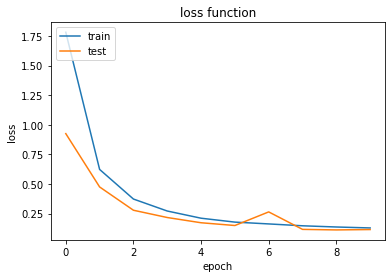

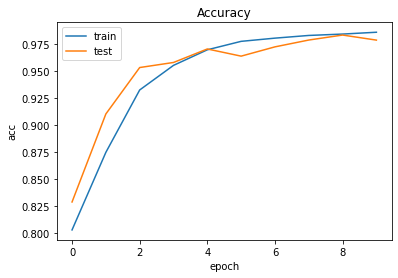

In [22]:
plt.plot(logs.history['loss'])
plt.plot(logs.history['val_loss'])
plt.title('loss function')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(logs.history['acc'])
plt.plot(logs.history['val_acc'])
plt.title('Accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### 4.1 Adquirir los mejores parametros del modelo entrenado

In [25]:
model.load_weights('RS_georgia_db.h5')

## 5. Generar predicción
Para este proyecto el test set serian las imagenes que vienen de la camara. Sin embargo, para probar la funcion se aplicara al validation set.

### 5.1 Creando generador de imagenes para el test set

In [26]:
def gen_test_flow_for_two_inputs(X1, X2, y,df,dire):
    genX1 =test_generator.flow_from_dataframe(dataframe=df,
                                                 directory=dire,
                                                 x_col=X1,
                                                 y_col=y,
                                                  target_size=(105,105),
                                                  batch_size=1,
                                                  class_mode="raw",
                                                  shuffle=False)
    genX2 = test_generator.flow_from_dataframe(dataframe=df,
                                                 directory=dire,
                                                 x_col=X2,
                                                 y_col=y,
                                                  target_size=(105,105),
                                                  batch_size=1,
                                                  class_mode="raw",
                                                  shuffle=False)
    while True:
                X1i = genX1.next()
                X2i = genX2.next()
                yield [X1i[0], X2i[0]]

In [27]:
def get_prediction(df,direccion_prediccion):
    predictions=model.predict_generator(gen_test_flow_for_two_inputs("Imagen1", "Imagen2", "Imagen2",
                                                                            df,direccion_prediccion), steps = 1)
    return predictions

### 5.2 Generando las predicciones por cada row del DataFrame

In [28]:
lista_predicciones=[]

for i in tqdm(range(len(df_val))):

    df_minitest=pd.DataFrame({"Imagen1":[df_val.loc[i,'Imagen1']],"Imagen2":[df_val.loc[i,'Imagen2']]})
    tensor = get_prediction(df_minitest,images_path)
    tensor=tensor.ravel()[0]

    lista_predicciones.append(tensor)

Instructions for updating:
Please use Model.predict, which supports generators.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 va

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated im

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated im

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated im

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated im

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated im

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated im

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated im

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated im

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated im

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated im

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated im

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated im

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated im

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated im

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated im

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated im

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated im

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated im

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated im

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated im

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated im

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated im

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated im

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated im

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated im

In [29]:
lista_final=np.array(lista_predicciones)

In [30]:
from sklearn.metrics import mean_absolute_error

In [31]:
mean_absolute_error(lista_final, list(df_val["Igualdad"]))

0.10860335749908526

### 5.3 Generando N way 

In [32]:
def predecir_n_way(n,nr_examples):
    lista_precision=[]
    cont=0
    random_2=0
    random2=0
    for i in tqdm(range(nr_examples)):
        lista_imagenes=[]
        lista_predicciones=[]

        random1=np.random.randint(49)
        random_1=np.random.randint(14)+1
        random_2=np.random.randint(14)+1
        unica_igualdad="s{}/{}.jpg".format(random1+1,random_1)

        while(random_2==random_1):
                random_2=np.random.randint(14)+1

        lista_imagenes.append("s{}/{}.jpg".format(random1+1,random_2))

        for k in range(n-1):
            random2=np.random.randint(49)
            while(random2==random1):
                random2=np.random.randint(49)
            lista_imagenes.append("s{}/{}.jpg".format(random2+1,np.random.randint(14)+1))


        df_n_way=pd.DataFrame({"Imagen1":unica_igualdad,"Imagen2":lista_imagenes,"Igualdad":[1]+[0]*(n-1)})

        for j in range(len(df_n_way)):

            df_minitest=pd.DataFrame({"Imagen1":[df_n_way.loc[j,'Imagen1']],"Imagen2":[df_n_way.loc[j,'Imagen2']]})
            tensor = get_prediction(df_minitest,images_path)
            tensor=tensor.ravel()[0]
            lista_predicciones.append(tensor) 
        argumento=np.argmax(lista_predicciones)
        if argumento ==0:
            lista_precision.append(1)
        else:
            lista_precision.append(0)
    
        print(i)
    print(np.sum(lista_precision)/len(lista_precision))
    return np.sum(lista_precision)/len(lista_precision)


In [34]:
Siamesa_20_way=predecir_n_way(20,1000)

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated im

5
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated 

11
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
17
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
23
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
29
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
35
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
41
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
47
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
53
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
59
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
65
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
71
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
77
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
83
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated im

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated im

Found 1 validated image filenames.
100
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
106
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
112
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
118
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
124
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
130
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
136
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
142
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
148
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
154
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated im

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated im

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated im

Found 1 validated image filenames.
Found 1 validated image filenames.
177
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
183
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
189
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
195
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
201
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
207
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
213
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated im

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated im

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated im

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated im

Found 1 validated image filenames.
Found 1 validated image filenames.
242
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
248
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
254
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
260
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
266
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
272
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
278
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
284
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
290
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
296
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
302
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
308
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
314
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
320
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
326
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
332
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
338
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
344
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
350
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
356
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated im

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated im

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated im

379
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
385
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
391
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
397
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
403
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
409
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
415
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
421
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
427
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
433
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
439
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
445
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
451
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
457
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
463
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
469
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
475
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
481
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
487
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
493
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
499
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated im

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated im

Found 1 validated image filenames.
Found 1 validated image filenames.
516
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
522
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
528
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
534
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
540
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
546
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
552
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
558
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
564
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
570
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
576
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
582
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
588
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated im

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
600
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated im

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated im

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated im

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated im

Found 1 validated image filenames.
Found 1 validated image filenames.
629
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
635
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
641
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
647
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
653
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
659
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
665
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated im

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated im

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated im

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated im

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated im

Found 1 validated image filenames.
Found 1 validated image filenames.
700
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
706
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
712
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
718
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
724
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
730
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
736
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
742
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
748
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
754
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
760
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
766
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
772
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
778
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
784
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
790
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
796
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated im

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated im

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated im

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated im

825
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

831
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
837
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
843
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
849
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
855
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
861
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
867
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
873
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
879
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated im

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated im

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated im

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated im

908
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
914
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
920
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
926
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
932
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
938
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated im

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated im

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated im

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated im

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated im

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated im

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated im

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
985
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
991
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
997
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

In [35]:
Siamesa_10_way=predecir_n_way(10,1000)

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
0
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated 

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
11
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
12
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 valida

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
23
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
24
Found 1 valida

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
35
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
47
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
59
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
71
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
83
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
95
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated

Found 1 validated image filenames.
Found 1 validated image filenames.
106
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
107
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 vali

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
118
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
119
Found 1 vali

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
130
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
142
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
154
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
166
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
177
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
178
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 vali

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
189
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
201
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
213
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
224
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
225
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 vali

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
236
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
237
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 vali

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
248
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
249
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 vali

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
260
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
261
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 vali

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
272
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
273
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 vali

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
284
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

295
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
296
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 vali

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
307
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
308
Found 1 validated image filenames.
Found 1 vali

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
319
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
320
Found 1 vali

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
331
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
343
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
355
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
367
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
378
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
379
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 vali

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
390
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
391
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 vali

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
402
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
403
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 vali

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
414
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
415
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 vali

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
426
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
427
Found 1 vali

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
438
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
450
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
462
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
473
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
474
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 vali

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
485
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
486
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 vali

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
497
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
498
Found 1 vali

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
509
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
521
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
532
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
533
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 vali

Found 1 validated image filenames.
Found 1 validated image filenames.
544
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
545
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 vali

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
556
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
557
Found 1 vali

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
568
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
580
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
592
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
604
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
615
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
616
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 vali

Found 1 validated image filenames.
Found 1 validated image filenames.
627
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
628
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 vali

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
639
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
640
Found 1 vali

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
651
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
663
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
674
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
675
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 vali

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
686
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
687
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 vali

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
698
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
699
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 vali

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
710
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
722
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
734
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
746
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
757
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
758
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 vali

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
769
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
781
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
793
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
805
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
816
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
817
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 vali

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
828
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
829
Found 1 vali

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
840
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
852
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
864
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
876
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
887
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
888
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 vali

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
899
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
900
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 vali

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
911
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
923
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
935
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
947
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
959
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
971
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validate

Found 1 validated image filenames.
Found 1 validated image filenames.
982
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
983
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 vali

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
994
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
995
Found 1 vali

In [36]:
Siamesa_4_way=predecir_n_way(4,1000)

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
0
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
1
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
2
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 valida

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
29
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
30
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
31
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 val

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
58
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
59
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
60
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 val

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
87
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
88
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
89
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
90
Found 1 

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
116
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
117
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
118
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
119
Foun

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
145
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
146
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
147
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
148
Foun

174
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
175
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
176
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
177
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Foun

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
204
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
205
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
206
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
233
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
234
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
235
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 

262
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
263
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
264
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
265
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Foun

291
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
292
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
293
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
294
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Foun

320
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
321
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
322
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
323
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Foun

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
350
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
351
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
352
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
380
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
381
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
382
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
409
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
410
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
411
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
412
Found 1 validated image filenames.
Foun

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
438
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
439
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
440
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
441
Foun

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
468
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
469
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
470
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 

497
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
498
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
499
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
500
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Foun

Found 1 validated image filenames.
Found 1 validated image filenames.
527
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
528
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
529
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
530
Found 1 validated image filenames.
Found 1 validated image filenames.
Foun

Found 1 validated image filenames.
Found 1 validated image filenames.
557
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
558
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
559
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
560
Found 1 validated image filenames.
Found 1 validated image filenames.
Foun

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
587
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
588
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
589
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
616
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
617
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
618
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 

Found 1 validated image filenames.
Found 1 validated image filenames.
645
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
646
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
647
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
648
Found 1 validated image filenames.
Found 1 validated image filenames.
Foun

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
675
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
676
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
677
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
678
Foun

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
705
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
706
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
707
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
708
Foun

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
735
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
736
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
737
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
738
Foun

764
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
765
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
766
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
767
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Foun

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
794
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
795
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
796
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
797
Foun

Found 1 validated image filenames.
Found 1 validated image filenames.
823
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
824
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
825
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
826
Found 1 validated image filenames.
Found 1 validated image filenames.
Foun

Found 1 validated image filenames.
Found 1 validated image filenames.
852
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
853
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
854
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
855
Found 1 validated image filenames.
Found 1 validated image filenames.
Foun

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
882
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
883
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
884
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
885
Foun

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
912
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
913
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
914
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
915
Foun

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
942
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
943
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
944
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
945
Foun

Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
972
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
973
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
974
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 validated image filenames.
Found 1 

In [37]:
Siamesa_20_way,Siamesa_10_way,Siamesa_4_way

(0.649, 0.759, 0.892)

In [38]:
Siamesa_resultados=pd.DataFrame({"N Way":["20 way","10 way","4 way"],"Precision":[Siamesa_20_way,Siamesa_10_way,Siamesa_4_way]})

In [39]:
Siamesa_resultados

,N Way,Precision
0,20 way,0.649
1,10 way,0.759
2,4 way,0.892


In [40]:
Siamesa_resultados.to_csv("Siamesa_resultados_nway.csv",index=False)